
# PACS-AI Assist — Exploración DICOM (LIDC-IDRI)

Este notebook te ayuda a:
1) (Opcional) **Descargar un subset pequeño** de LIDC-IDRI desde la API de TCIA.
2) **Listar archivos DICOM** en tu carpeta `data/`.
3) **Cargar y visualizar** una imagen DICOM con `pydicom` + `matplotlib`.
4) **Ver metadatos clave** (PatientID, Modality, Spacing, etc.).

> Si **ya descargaste** DICOMs con NBIA (app gráfica), basta con apuntar la variable `DATA_DIR` a tu carpeta local y saltarte la celda de descarga.


In [1]:

# 🔧 Dependencias (ejecuta una sola vez por entorno)
# Si ya las tienes instaladas, puedes saltarte esta celda.
%pip install --quiet pydicom matplotlib tcia_utils


Note: you may need to restart the kernel to use updated packages.


In [5]:
from pathlib import Path

DATA_DIR = Path("data/LIDC-IDRI_subset/manifest-1756535103894/LIDC-IDRI")
print(DATA_DIR.resolve())


C:\Users\Diego Castañeda\Documents\PACS-IA Assist\data\LIDC-IDRI_subset\manifest-1756535103894\LIDC-IDRI



## (Opcional) Descargar un subset pequeño vía API de TCIA

- Esto usa `tcia_utils` para listar pacientes y descargar **una serie por paciente**.
- Por defecto baja 5 pacientes para no llenar tu disco.
- Si prefieres, **sáltate** esta sección y usa NBIA + manifest `.tcia` (clics).

In [6]:

DO_DOWNLOAD = False   # ⬅️ cambia a True si quieres bajar vía API

if DO_DOWNLOAD:
    from tcia_utils import nbia
    import time
    
    COLLECTION = "LIDC-IDRI"
    MAX_PATIENTS = 5  # controla cuántos pacientes bajas
    print(f"Listando pacientes de {COLLECTION} ...")
    patients = nbia.get_patient(collection=COLLECTION)
    subset = patients[:MAX_PATIENTS]
    print(f"Bajaremos {len(subset)} pacientes")

    for i, p in enumerate(subset, 1):
        pid = p["PatientID"]
        print(f"[{i}/{len(subset)}] Paciente: {pid}")
        studies = nbia.get_studies(collection=COLLECTION, patientId=pid) or []
        if not studies:
            print("  - sin estudios, salto"); 
            continue
        series = nbia.get_series(collection=COLLECTION, patientId=pid,
                                 studyInstanceUid=studies[0]["StudyInstanceUID"]) or []
        if not series:
            print("  - sin series, salto")
            continue
        series_uid = series[0]["SeriesInstanceUID"]
        out_dir = DATA_DIR / pid
        out_dir.mkdir(parents=True, exist_ok=True)
        print("  - Descargando serie:", series_uid)
        nbia.download_series(seriesInstanceUid=series_uid, downloadPath=str(out_dir))
        time.sleep(0.5)
        
    print("✅ Descarga finalizada")
else:
    print("Descarga por API desactivada (DO_DOWNLOAD=False). Usa NBIA o habilita la bandera.")


Descarga por API desactivada (DO_DOWNLOAD=False). Usa NBIA o habilita la bandera.


In [12]:
from pathlib import Path
DATA_ROOT = Path("data/LIDC-IDRI_subset/manifest-1756535103894/LIDC-IDRI")
print(DATA_ROOT.resolve())


C:\Users\Diego Castañeda\Documents\PACS-IA Assist\data\LIDC-IDRI_subset\manifest-1756535103894\LIDC-IDRI


In [18]:
from pathlib import Path

BASE = Path("data/LIDC-IDRI_subset")
assert BASE.exists(), f"No existe {BASE.resolve()}"

# Busca automáticamente el folder del manifest (cambia cada descarga)
manifests = sorted([p for p in BASE.iterdir() if p.is_dir() and p.name.startswith("manifest-")])
assert manifests, f"No encontré carpetas 'manifest-*' dentro de {BASE.resolve()}"
MANIFEST_DIR = manifests[-1]  # toma el más reciente
print("MANIFEST_DIR:", MANIFEST_DIR.resolve())

DATA_ROOT = MANIFEST_DIR / "LIDC-IDRI"
assert DATA_ROOT.exists(), f"No existe {DATA_ROOT.resolve()}"
print("DATA_ROOT:", DATA_ROOT.resolve())

# Muestra qué hay adentro (deberían estar LIDC-IDRI-0001, 0002, 0003…)
print("Subcarpetas de pacientes:", [p.name for p in DATA_ROOT.iterdir() if p.is_dir()])


MANIFEST_DIR: C:\Users\Diego Castañeda\Documents\PACS-IA Assist\data\LIDC-IDRI_subset\manifest-1756535103984
DATA_ROOT: C:\Users\Diego Castañeda\Documents\PACS-IA Assist\data\LIDC-IDRI_subset\manifest-1756535103984\LIDC-IDRI
Subcarpetas de pacientes: ['LIDC-IDRI-0001', 'LIDC-IDRI-0002', 'LIDC-IDRI-0003']


In [19]:
from pathlib import Path

dcm_list = list(DATA_ROOT.rglob("*.dcm"))
print(f"Total DICOMs encontrados: {len(dcm_list)}")
for p in dcm_list[:5]:
    print(" -", p)


Total DICOMs encontrados: 570
 - data\LIDC-IDRI_subset\manifest-1756535103984\LIDC-IDRI\LIDC-IDRI-0001\01-01-2000-NA-NA-30178\3000566.000000-NA-03192\1-001.dcm
 - data\LIDC-IDRI_subset\manifest-1756535103984\LIDC-IDRI\LIDC-IDRI-0001\01-01-2000-NA-NA-30178\3000566.000000-NA-03192\1-002.dcm
 - data\LIDC-IDRI_subset\manifest-1756535103984\LIDC-IDRI\LIDC-IDRI-0001\01-01-2000-NA-NA-30178\3000566.000000-NA-03192\1-003.dcm
 - data\LIDC-IDRI_subset\manifest-1756535103984\LIDC-IDRI\LIDC-IDRI-0001\01-01-2000-NA-NA-30178\3000566.000000-NA-03192\1-004.dcm
 - data\LIDC-IDRI_subset\manifest-1756535103984\LIDC-IDRI\LIDC-IDRI-0001\01-01-2000-NA-NA-30178\3000566.000000-NA-03192\1-005.dcm


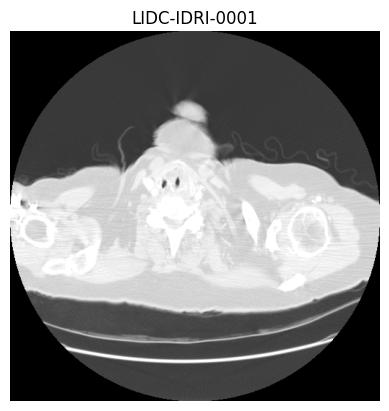

In [21]:
import pydicom, matplotlib.pyplot as plt, numpy as np

if not dcm_list:
    raise SystemExit("No hay .dcm. Revisa rutas/descarga.")
ds = pydicom.dcmread(dcm_list[0])
arr = ds.pixel_array.astype(np.float32)
slope = float(getattr(ds, "RescaleSlope", 1.0) or 1.0)
intercept = float(getattr(ds, "RescaleIntercept", 0.0) or 0.0)
hu = arr * slope + intercept
wl, ww = -600.0, 1500.0
vmin, vmax = wl - ww/2, wl + ww/2
plt.imshow(hu, cmap="gray", vmin=vmin, vmax=vmax); plt.axis("off"); plt.title(getattr(ds,"PatientID","?"))
plt.show()


In [22]:
import pandas as pd

meta_csv = MANIFEST_DIR / "metadata.csv"
print("Buscando metadata en:", meta_csv.resolve())
if meta_csv.exists():
    meta = pd.read_csv(meta_csv)
    print(meta.shape)
    display(meta.head())
else:
    print("⚠️ No encontré metadata.csv en", meta_csv)


Buscando metadata en: C:\Users\Diego Castañeda\Documents\PACS-IA Assist\data\LIDC-IDRI_subset\manifest-1756535103984\metadata.csv
(35, 17)


,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
1.2.276.0.7230010.3.1.3.0.89453.1553284117.905274,LIDC-IDRI,yes,https://doi.org/10.7937/TCIA.2018.h7umfurq,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,NaN,01-01-2000,Segmentation of Nodule 1 - Annotation MI01411691,QIICR,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,939,57 KB,.\LIDC-IDRI\LIDC-IDRI-0002\01-01-2000-NA-NA-98...,2025-08-30T02:26:43.883
1.2.276.0.7230010.3.1.3.0.89454.1553284121.39902,LIDC-IDRI,yes,https://doi.org/10.7937/TCIA.2018.h7umfurq,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,NaN,01-01-2000,Nodule 1 - Annotation MI01411691 evaluations,QIICR,SR,Enhanced SR Storage,1.2.840.10008.5.1.4.1.1.88.22,1,172,74 KB,.\LIDC-IDRI\LIDC-IDRI-0002\01-01-2000-NA-NA-98...,2025-08-30T02:26:45.124
1.2.276.0.7230010.3.1.3.0.89455.1553284125.863850,LIDC-IDRI,yes,https://doi.org/10.7937/TCIA.2018.h7umfurq,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,NaN,01-01-2000,Segmentation of Nodule 1 - Annotation 8,QIICR,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,772,22 KB,.\LIDC-IDRI\LIDC-IDRI-0002\01-01-2000-NA-NA-98...,2025-08-30T02:26:46.756
1.2.276.0.7230010.3.1.3.0.89456.1553284129.203669,LIDC-IDRI,yes,https://doi.org/10.7937/TCIA.2018.h7umfurq,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,NaN,01-01-2000,Nodule 1 - Annotation 8 evaluations,QIICR,SR,Enhanced SR Storage,1.2.840.10008.5.1.4.1.1.88.22,1,172,72 KB,.\LIDC-IDRI\LIDC-IDRI-0002\01-01-2000-NA-NA-98...,2025-08-30T02:26:47.972
1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,NaN,01-01-2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,133,70,33 MB,.\LIDC-IDRI\LIDC-IDRI-0001\01-01-2000-NA-NA-30...,2025-08-30T02:26:48.928


In [23]:
from pathlib import Path
import os, csv
import pydicom

# 👉 ajusta solo esta ruta base (la carpeta que contiene LIDC-IDRI-0001, 0002, 0003…)
DATA_ROOT = Path("data/LIDC-IDRI_subset").resolve()

# autodetecta el manifest más reciente y la carpeta LIDC-IDRI
manifests = sorted([p for p in (DATA_ROOT).iterdir() if p.is_dir() and p.name.startswith("manifest-")])
if manifests:
    DATA_ROOT = manifests[-1] / "LIDC-IDRI"
print("DATA_ROOT =", DATA_ROOT)

assert DATA_ROOT.exists(), f"No existe {DATA_ROOT}"

out_csv = DATA_ROOT.parent / "index_dicom.csv"   # guarda al lado de LIDC-IDRI
fields = [
    "PatientID","StudyInstanceUID","SeriesInstanceUID","SOPInstanceUID",
    "InstanceNumber","Rows","Columns","SliceThickness",
    "PixelSpacing","ImagePositionPatient","ImageOrientationPatient",
    "Modality","SeriesDescription","FilePath"
]

rows = []
count = 0
for root, _, files in os.walk(DATA_ROOT):
    for f in files:
        if not f.lower().endswith(".dcm"):
            continue
        path = Path(root) / f
        try:
            ds = pydicom.dcmread(path, stop_before_pixels=True, force=True)
            def get(tag, default=None):
                return getattr(ds, tag, default)
            rows.append({
                "PatientID":               get("PatientID"),
                "StudyInstanceUID":       get("StudyInstanceUID"),
                "SeriesInstanceUID":      get("SeriesInstanceUID"),
                "SOPInstanceUID":         get("SOPInstanceUID"),
                "InstanceNumber":         get("InstanceNumber"),
                "Rows":                   get("Rows"),
                "Columns":                get("Columns"),
                "SliceThickness":         get("SliceThickness"),
                "PixelSpacing":           str(get("PixelSpacing")),
                "ImagePositionPatient":   str(get("ImagePositionPatient")),
                "ImageOrientationPatient":str(get("ImageOrientationPatient")),
                "Modality":               get("Modality"),
                "SeriesDescription":      get("SeriesDescription"),
                "FilePath":               str(path)
            })
            count += 1
            if count % 500 == 0:
                print(f"Indexando... {count}")
        except Exception as e:
            print("⚠️ Error leyendo", path, "-", e)

# guardar CSV
with open(out_csv, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=fields)
    w.writeheader()
    w.writerows(rows)

print(f"✅ Index creado: {out_csv} ({len(rows)} filas)")


DATA_ROOT = C:\Users\Diego Castañeda\Documents\PACS-IA Assist\data\LIDC-IDRI_subset\manifest-1756535103984\LIDC-IDRI
Indexando... 500
✅ Index creado: C:\Users\Diego Castañeda\Documents\PACS-IA Assist\data\LIDC-IDRI_subset\manifest-1756535103984\index_dicom.csv (570 filas)


In [24]:
import pandas as pd
idx = pd.read_csv(out_csv)
print("Filas:", len(idx))
print("Pacientes únicos:", idx["PatientID"].nunique())
print("Series únicas:", idx["SeriesInstanceUID"].nunique())

display(
    idx.groupby(["PatientID","SeriesInstanceUID"])["SOPInstanceUID"].count()
      .rename("num_imagenes").reset_index()
      .sort_values(["PatientID","num_imagenes"], ascending=[True,False]).head(10)
)

display(idx.head(8))


Filas: 570
Pacientes únicos: 3
Series únicas: 35


,PatientID,SeriesInstanceUID,num_imagenes
0,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,133
6,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,261
1,LIDC-IDRI-0002,1.2.276.0.7230010.3.1.3.0.89453.1553284117.905274,1
2,LIDC-IDRI-0002,1.2.276.0.7230010.3.1.3.0.89454.1553284121.39902,1
3,LIDC-IDRI-0002,1.2.276.0.7230010.3.1.3.0.89455.1553284125.863850,1
4,LIDC-IDRI-0002,1.2.276.0.7230010.3.1.3.0.89456.1553284129.203669,1
5,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.493562949900...,1
34,LIDC-IDRI-0003,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,140
33,LIDC-IDRI-0003,1.3.6.1.4.1.14519.5.2.1.6279.6001.142026812390...,5
7,LIDC-IDRI-0003,1.2.276.0.7230010.3.1.3.0.89502.1553284149.555761,1


,PatientID,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,InstanceNumber,Rows,Columns,SliceThickness,PixelSpacing,ImagePositionPatient,ImageOrientationPatient,Modality,SeriesDescription,FilePath
0,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1.3.6.1.4.1.14519.5.2.1.6279.6001.262721256650...,1,512.0,512.0,2.5,"[0.703125, 0.703125]","[-166.000000, -171.699997, -10.000000]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",CT,NaN,C:\Users\Diego Castañeda\Documents\PACS-IA Ass...
1,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1.3.6.1.4.1.14519.5.2.1.6279.6001.512235483218...,2,512.0,512.0,2.5,"[0.703125, 0.703125]","[-166.000000, -171.699997, -12.500000]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",CT,NaN,C:\Users\Diego Castañeda\Documents\PACS-IA Ass...
2,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1.3.6.1.4.1.14519.5.2.1.6279.6001.806997748376...,3,512.0,512.0,2.5,"[0.703125, 0.703125]","[-166.000000, -171.699997, -15.000000]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",CT,NaN,C:\Users\Diego Castañeda\Documents\PACS-IA Ass...
3,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1.3.6.1.4.1.14519.5.2.1.6279.6001.206640541506...,4,512.0,512.0,2.5,"[0.703125, 0.703125]","[-166.000000, -171.699997, -17.500000]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",CT,NaN,C:\Users\Diego Castañeda\Documents\PACS-IA Ass...
4,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1.3.6.1.4.1.14519.5.2.1.6279.6001.144082670553...,5,512.0,512.0,2.5,"[0.703125, 0.703125]","[-166.000000, -171.699997, -20.000000]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",CT,NaN,C:\Users\Diego Castañeda\Documents\PACS-IA Ass...
5,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1.3.6.1.4.1.14519.5.2.1.6279.6001.258803092646...,6,512.0,512.0,2.5,"[0.703125, 0.703125]","[-166.000000, -171.699997, -22.500000]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",CT,NaN,C:\Users\Diego Castañeda\Documents\PACS-IA Ass...
6,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1.3.6.1.4.1.14519.5.2.1.6279.6001.166236089135...,7,512.0,512.0,2.5,"[0.703125, 0.703125]","[-166.000000, -171.699997, -25.000000]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",CT,NaN,C:\Users\Diego Castañeda\Documents\PACS-IA Ass...
7,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1.3.6.1.4.1.14519.5.2.1.6279.6001.265932952157...,8,512.0,512.0,2.5,"[0.703125, 0.703125]","[-166.000000, -171.699997, -27.500000]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",CT,NaN,C:\Users\Diego Castañeda\Documents\PACS-IA Ass...


In [27]:
from pathlib import Path

print("CWD =", Path.cwd())

BASE = Path("data/LIDC-IDRI_subset")
assert BASE.exists(), f"No existe {BASE.resolve()}"

# encontrar carpeta manifest-* más reciente
manifests = sorted([p for p in BASE.iterdir() if p.is_dir() and p.name.startswith("manifest-")])
assert manifests, f"No encontré 'manifest-*' dentro de {BASE.resolve()}"
MANIFEST_DIR = manifests[-1]
print("MANIFEST_DIR:", MANIFEST_DIR)

DATA_ROOT = MANIFEST_DIR / "LIDC-IDRI"
assert DATA_ROOT.exists(), f"No existe {DATA_ROOT}"
print("DATA_ROOT:", DATA_ROOT)

patients = [p for p in DATA_ROOT.iterdir() if p.is_dir() and p.name.startswith("LIDC-IDRI-")]
print("Pacientes detectados:", [p.name for p in patients])
assert patients, "No hay carpetas de pacientes dentro de LIDC-IDRI"


CWD = c:\Users\Diego Castañeda\Documents\PACS-IA Assist
MANIFEST_DIR: data\LIDC-IDRI_subset\manifest-1756535103984
DATA_ROOT: data\LIDC-IDRI_subset\manifest-1756535103984\LIDC-IDRI
Pacientes detectados: ['LIDC-IDRI-0001', 'LIDC-IDRI-0002', 'LIDC-IDRI-0003']


In [28]:
from collections import defaultdict

counts = {}
for p in patients:
    n = sum(1 for _ in p.rglob("*.dcm"))
    counts[p] = n
    print(f"{p.name}: {n}")

# elige el paciente con más imágenes
patient_dir = max(counts, key=counts.get)
print("Elegido:", patient_dir.name, "->", counts[patient_dir], "imágenes")

# lista algunos archivos para confirmar
sample_list = list(patient_dir.rglob("*.dcm"))[:5]
for s in sample_list:
    print(" -", s)


LIDC-IDRI-0001: 133
LIDC-IDRI-0002: 266
LIDC-IDRI-0003: 171
Elegido: LIDC-IDRI-0002 -> 266 imágenes
 - data\LIDC-IDRI_subset\manifest-1756535103984\LIDC-IDRI\LIDC-IDRI-0002\01-01-2000-NA-NA-26851\3000972.000000-NA-22902\1-1.dcm
 - data\LIDC-IDRI_subset\manifest-1756535103984\LIDC-IDRI\LIDC-IDRI-0002\01-01-2000-NA-NA-98329\3000522.000000-NA-04919\1-001.dcm
 - data\LIDC-IDRI_subset\manifest-1756535103984\LIDC-IDRI\LIDC-IDRI-0002\01-01-2000-NA-NA-98329\3000522.000000-NA-04919\1-002.dcm
 - data\LIDC-IDRI_subset\manifest-1756535103984\LIDC-IDRI\LIDC-IDRI-0002\01-01-2000-NA-NA-98329\3000522.000000-NA-04919\1-003.dcm
 - data\LIDC-IDRI_subset\manifest-1756535103984\LIDC-IDRI\LIDC-IDRI-0002\01-01-2000-NA-NA-98329\3000522.000000-NA-04919\1-004.dcm


Total archivos encontrados para LIDC-IDRI-0002: 266


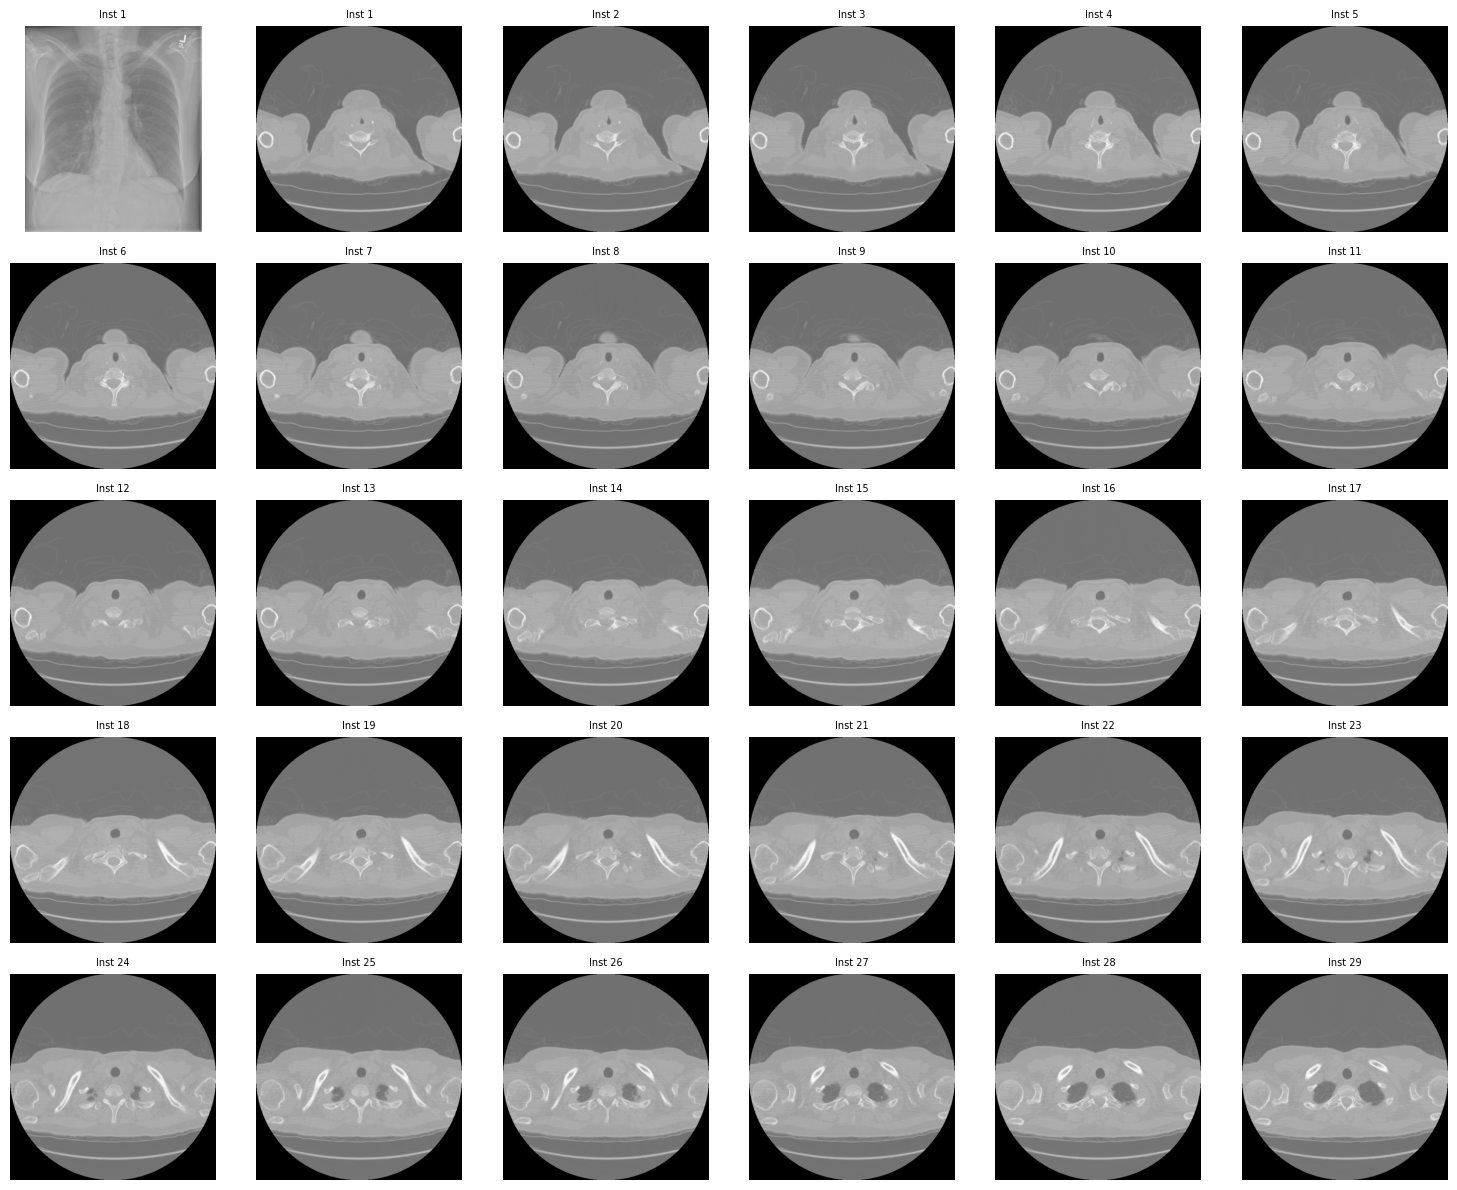

In [29]:
import pydicom
import matplotlib.pyplot as plt

dcm_files = sorted(patient_dir.rglob("*.dcm"))
print(f"Total archivos encontrados para {patient_dir.name}: {len(dcm_files)}")
assert dcm_files, "Sigue en 0: la ruta no contiene .dcm. Mándame lo que imprimió la celda anterior."

sample_files = dcm_files[:30]

fig, axes = plt.subplots(5, 6, figsize=(15, 12))
axes = axes.flatten()

for ax, f in zip(axes, sample_files):
    ds = pydicom.dcmread(f)
    ax.imshow(ds.pixel_array, cmap="gray")
    ax.axis("off")
    ax.set_title(f"Inst {getattr(ds,'InstanceNumber','?')}", fontsize=7)

for ax in axes[len(sample_files):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [30]:
%pip install ipywidgets


   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 62.4 MB/s  0:00:00

   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   ---------------------------------------- 3/3 [ipywidgets]

Note: you may need to restart the kernel to use updated packages.


In [33]:
from pathlib import Path
import pydicom, numpy as np, matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Carpeta "LIDC-IDRI" que contiene LIDC-IDRI-0001, 0002, 0003...
BASE_DIR = Path("data/LIDC-IDRI_subset")
# autodetectar manifest/LIDC-IDRI
manifests = sorted([p for p in BASE_DIR.iterdir() if p.is_dir() and p.name.startswith("manifest-")])
assert manifests, f"No encontré 'manifest-*' bajo {BASE_DIR.resolve()}"
DATA_ROOT = manifests[-1] / "LIDC-IDRI"

# 1) Agrupar por serie dentro del paciente con más archivos .dcm
patients = [p for p in DATA_ROOT.iterdir() if p.is_dir() and p.name.startswith("LIDC-IDRI-")]
assert patients, "No hay carpetas de pacientes"

# elige el paciente con más .dcm en total
patient_dir = max(patients, key=lambda p: sum(1 for _ in p.rglob("*.dcm")))
print("Paciente elegido:", patient_dir.name)

# mapear series -> lista de archivos
from collections import defaultdict
series_files = defaultdict(list)
for fp in patient_dir.rglob("*.dcm"):
    try:
        ds = pydicom.dcmread(fp, stop_before_pixels=True, force=True)
        uid = getattr(ds, "SeriesInstanceUID", None)
        if uid:
            series_files[uid].append(fp)
    except Exception:
        pass

print("Series detectadas:", len(series_files))

# 2) Elegir la PRIMERA serie que realmente tenga PixelData utilizable
def can_read_pixels(fp: Path) -> bool:
    try:
        ds = pydicom.dcmread(fp, force=True)  # leer completo
        _ = ds.pixel_array  # probar acceso
        return True
    except Exception:
        return False

chosen_uid, chosen_list = None, None
for uid, files in sorted(series_files.items(), key=lambda kv: -len(kv[1])):  # de mayor a menor
    # prueba con 1–2 archivos de la serie
    test_ok = any(can_read_pixels(f) for f in files[:2])
    if test_ok:
        chosen_uid, chosen_list = uid, files
        break

assert chosen_uid is not None, "No encontré ninguna serie con PixelData utilizable en este paciente."

print("Serie elegida:", chosen_uid, "con", len(chosen_list), "archivos")

# 3) Ordenar y apilar volumen (por Z o InstanceNumber)
def order_key(fp: Path):
    ds = pydicom.dcmread(fp, stop_before_pixels=True, force=True)
    ipp = getattr(ds, "ImagePositionPatient", None)
    if ipp and len(ipp) == 3:
        return float(ipp[2])
    inst = getattr(ds, "InstanceNumber", None)
    return (inst is None, inst, str(fp))

files_sorted = sorted(chosen_list, key=order_key)

# leer a HU
slices = []
example = pydicom.dcmread(files_sorted[0], force=True)
slope = float(getattr(example, "RescaleSlope", 1.0) or 1.0)
intercept = float(getattr(example, "RescaleIntercept", 0.0) or 0.0)
for fp in files_sorted:
    ds = pydicom.dcmread(fp, force=True)
    arr = ds.pixel_array.astype(np.float32) * slope + intercept
    slices.append(arr)

VOL = np.stack(slices, axis=0)  # (z,y,x)
spacing = getattr(example, "PixelSpacing", [1,1])
slice_thk = float(getattr(example, "SliceThickness", 1.0) or 1.0)
print("Volumen shape:", VOL.shape, " | SliceThickness:", slice_thk, " | PixelSpacing:", spacing)

# 4) Sliders
def show_slice(k:int, plane="axial", wl=-600.0, ww=1500.0):
    vmin, vmax = wl - ww/2, wl + ww/2
    if plane == "axial":
        img = VOL[k]
    elif plane == "coronal":
        img = VOL[:, k, :]
    else:
        img = VOL[:, :, k]
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.show()

print("Axial")
_ = interact(lambda k: show_slice(k, "axial"),
             k=IntSlider(min=0, max=VOL.shape[0]-1, step=1, value=VOL.shape[0]//2))
print("Coronal")
_ = interact(lambda k: show_slice(k, "coronal"),
             k=IntSlider(min=0, max=VOL.shape[1]-1, step=1, value=VOL.shape[1]//2))
print("Sagital")
_ = interact(lambda k: show_slice(k, "sagittal"),
             k=IntSlider(min=0, max=VOL.shape[2]-1, step=1, value=VOL.shape[2]//2))


Paciente elegido: LIDC-IDRI-0002
Series detectadas: 6
Serie elegida: 1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919 con 261 archivos
Volumen shape: (261, 512, 512)  | SliceThickness: 1.25  | PixelSpacing: [0.681641, 0.681641]
Axial


interactive(children=(IntSlider(value=130, description='k', max=260), Output()), _dom_classes=('widget-interac…

Coronal


interactive(children=(IntSlider(value=256, description='k', max=511), Output()), _dom_classes=('widget-interac…

Sagital


interactive(children=(IntSlider(value=256, description='k', max=511), Output()), _dom_classes=('widget-interac…

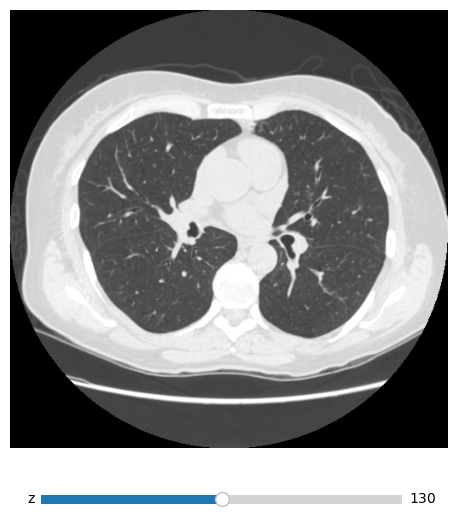

In [34]:
import numpy as np, matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Asumo que ya tienes VOL (z,y,x). Si no, ejecuta antes el bloque que lo construye.
wl, ww = -600.0, 1500.0
vmin, vmax = wl - ww/2, wl + ww/2

z0 = VOL.shape[0] // 2
fig, ax = plt.subplots(figsize=(6,6))
plt.subplots_adjust(bottom=0.15)  # espacio para el slider
im = ax.imshow(VOL[z0], cmap="gray", vmin=vmin, vmax=vmax)
ax.axis("off")

# Slider en el eje Z (axial)
ax_z = plt.axes([0.20, 0.05, 0.60, 0.03])
s_z = Slider(ax_z, "z", 0, VOL.shape[0]-1, valinit=z0, valstep=1)

def update(val):
    z = int(s_z.val)
    im.set_data(VOL[z])
    fig.canvas.draw_idle()

s_z.on_changed(update)
plt.show()


In [ ]:
import ipywidgets as w
w.IntSlider()


: 